In [1]:
import tensorflow as tf
from sklearn.cross_validation import train_test_split
import sys
from sklearn.utils import shuffle
import h5py
import time
import seaborn as ses

from IPython import display
import pylab as pl

%matplotlib inline

/home/moroclash/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Model of multi-layer LSTM using tensorflow LSTM cell

### load X,Y Data from folder /Data

In [2]:
def restore (nameOfFile,nameOfDataset):
    h5f = h5py.File(nameOfFile,'r')
    matrix = h5f[nameOfDataset][:]
    h5f.close()
    return matrix

In [3]:
X = restore("Data/data_matrix_X.h5","X")
Y = restore("Data/data_matrix_Y.h5","Y")

x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.40,random_state=42)
x_validate,x_test,y_validate,y_test = train_test_split(x_test,y_test,test_size=0.50,random_state=42)

In [4]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(x_validate.shape)
print(y_validate.shape)

(700, 83, 27)
(700, 2)
(234, 83, 27)
(234, 2)
(233, 83, 27)
(233, 2)


### model tuning parameters

In [6]:
# size of input vector
input_size = 27
# nimber of hidden unit
hidden_size = 80
# number of output vector
output_size = 2

layer_num = 2

dropout = 0.4

learn_rate = 0.001

batch_size = 700
epoch_number = 1300

## Define Model

In [7]:
class LstmCell(object):
    
    def __init__(self,input_size , hidden_size , output_size, layer_number,dropout):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.layer_number = layer_number
        self.dropout = dropout
        
        #weight of output layer
        self.vo = tf.Variable(
            tf.random_normal([self.hidden_size,output_size],
                             mean=0,stddev=0.01,seed=1),name='vo')
        self.bo = tf.Variable(
            tf.ones([self.output_size]),name='bo')
        
        #define shape of input matrix  
        self.inputs_matrix = tf.placeholder(
            dtype=tf.float32 ,shape=[None,None,self.input_size],name='inputs_matrix')
        
    def get_outputs(self):
        """get all output for all states
    
        Returns:
            all_outputs: output matrix for all state  

        Note:
            returned matrix size (state_numbers , batch_number , output_size )
        """
        Lstm_cells = []
        #prepare LSTM cell to create multi layer NN
        for i in range(self.layer_number):
            # define new cell
            cell = tf.contrib.rnn.LSTMCell(self.hidden_size)
            #apply dropout to reduce overfiting
            cell = tf.contrib.rnn.DropoutWrapper(cell,output_keep_prob=1.0- dropout)
            #apend defined cell as sequances 
            Lstm_cells.append(cell)
            
        #apply multi layer RNN
        final_cell = tf.contrib.rnn.MultiRNNCell(Lstm_cells)
        
        #get outputs
        all_outputs , states = tf.nn.dynamic_rnn(final_cell, self.inputs_matrix, dtype=tf.float32)
        #transfare data to get last time step
        all_outputs = tf.transpose(all_outputs, [1, 0, 2])
        return all_outputs
    

## Define Model

In [8]:
# define LstmCell class
rnn = LstmCell(hidden_size=hidden_size,
              input_size=input_size,
              output_size=output_size,
              dropout=dropout,
              layer_number=layer_num)

#get all outputs 
outputs = rnn.get_outputs()

#get last state for batch
last_output = tf.gather(outputs, x_train.shape[1] - 1)

#apply softmax on all last states
output = tf.nn.softmax(tf.matmul(last_output,rnn.vo)+rnn.bo)

#define shape of y
y = tf.placeholder(tf.float32,shape=[None,output_size])

#compute Cost_function 
cross_entropy = -tf.reduce_sum(y * tf.log(tf.clip_by_value(output,1e-10,1.0)))/batch_size

#use AdamOptmizer to reduece error
optmizer_step = tf.train.AdamOptimizer().minimize(cross_entropy)

#compute accuracy
correct_prediction = tf.equal(tf.argmax(y,1),tf.argmax(output,1))
accuracy = (tf.reduce_sum(tf.cast(correct_prediction,tf.float32)))*100

# # compute error 
# mistakes = tf.not_equal(tf.argmax(target, 1), tf.argmax(prediction, 1))
# error = tf.reduce_mean(tf.cast(mistakes, tf.float32))

/home/moroclash/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


## Train Model


In [9]:
sess = tf.Session()
sess.run(tf.initialize_all_variables())
saver = tf.train.Saver()

Instructions for updating:
Use `tf.global_variables_initializer` instead.


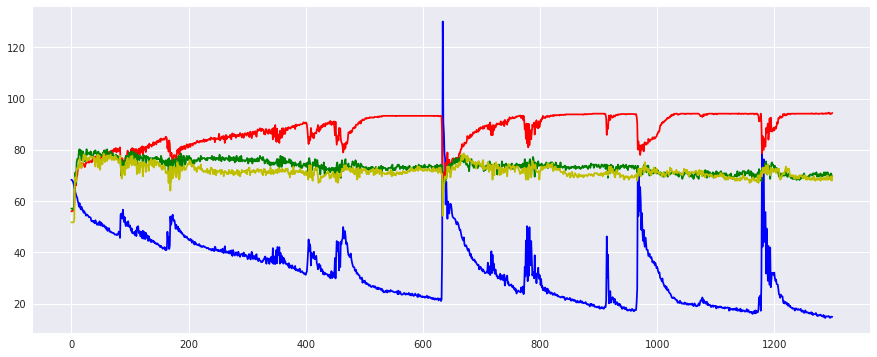

         Iteration:      1299 
               Loss:      14.8304656148 
     Train-Accuracy:      94.4285714286 
  Validate-Accuracy:      69.5278969957 
      test-Accuracy:      69.6581196581 

Improve count :: 9     74.2857142857   80.2575107296   76.4957264957

--- 200.64600168863933 minute ---


In [11]:
start_time = time.time()
loss_fig=[]
test_accuracy_fig=[]
train_accuracy_fig=[]
validate_accuracy_fig=[]
epoch_fig=[]

best_validate_accuracy =0
bvc_test_accuracy=0
bvc_train_accuracy=0
improve_count = 0

def print_info():
    pl.figure(figsize=(15,6))
    pl.plot(epoch_fig,loss_fig,'b')
    pl.plot(epoch_fig,train_accuracy_fig,'r')
    pl.plot(epoch_fig,validate_accuracy_fig,'g')
    pl.plot(epoch_fig,test_accuracy_fig,'y')
    pl.show()

    sys.stdout.flush()
    print("\r         Iteration:      %s \n" 
          "               Loss:      %s \n"  
          "     Train-Accuracy:      %s \n"
          "  Validate-Accuracy:      %s \n"
          "      test-Accuracy:      %s \n"%(epoch,loss,train_accuracy,validate_acuuracy,test_acuuracy))
    print("Improve count :: %s     %s   %s   %s"%(improve_count,
                                                  bvc_train_accuracy,
                                                  best_validate_accuracy,
                                                  bvc_test_accuracy))
    sys.stdout.flush()



pl.ion() 
for epoch in range(epoch_number):
    start = 0
    end = batch_size
    batchs_num = int(x_train.shape[0]/batch_size)
    for i in range(batchs_num):
        X = x_train[start:end]
        Y = y_train[start:end]
        start=end
        end=end+batch_size
        sess.run(optmizer_step,feed_dict={rnn.inputs_matrix:X,y:Y})
    
    loss = sess.run(cross_entropy,feed_dict={rnn.inputs_matrix:X,y:Y})*100
    train_accuracy = sess.run(accuracy,feed_dict={rnn.inputs_matrix:x_train,y:y_train}) / len(x_train)
    validate_acuuracy = sess.run(accuracy,feed_dict={rnn.inputs_matrix:x_validate,y:y_validate}) / len(x_validate)
    test_acuuracy = sess.run(accuracy,feed_dict={rnn.inputs_matrix:x_test,y:y_test}) / len(x_test)

    #check best accuracy to save best pramaters
    if(best_validate_accuracy < validate_acuuracy):
        best_validate_accuracy=validate_acuuracy
        saver.save(sess, 'Pramaters/Model_4_using_TF_LSTM')
        improve_count = improve_count+1
        bvc_test_accuracy=test_acuuracy
        bvc_train_accuracy=train_accuracy
        
    epoch_fig.append(epoch)
    loss_fig.append(loss)
    train_accuracy_fig.append(train_accuracy)
    validate_accuracy_fig.append(validate_acuuracy)
    test_accuracy_fig.append(test_acuuracy)
    

    print_info()
    display.clear_output(wait=True)

    
print_info()
print("\n--- %s minute ---" % ((time.time() - start_time)/60))

# Model Info

 * input layer :: 27
 * hidden layer units :: 160
 * output layer :: 2
 
 * multi-layer TF LSTM
 * dropout = 0.4
 * layer number : 2
 * epoch : 1300
 * batch size : 700  "all training set"

 
 
  after 1300 epoch :    there is over fiting
 * Train-Accuracy:      94.4285714286 
 * Validate-Accuracy:      69.5278969957 
 * test-Accuracy:      69.6581196581
 
 
 #### note : we save pramaters after reach to the best Validate accurecy aftert 9 improvement 
 ####            best Validate accuracy : 80.257%
 ####  we use Gradient Clipping to reduce the effect of vanishing problem and Dropout to reduce overfiting

## Test model 

In [ ]:
#get all outputs of test set
test_outputs = rnn.get_outputs()
sess.run(test_outputs,feed_dict={rnn.inputs_matrix:x_test})
#get last state of last time step
last_test_output = test_outputs[-1]


In [ ]:
#apply softmax on last_test_output
y_predict = sess.run(tf.nn.softmax(last_test_output),feed_dict={rnn.inputs_matrix:x_test})

In [ ]:
#compute accuracy
correct_prediction = tf.equal(tf.argmax(y_predict,1),tf.argmax(y_test,1))
accuracy = (tf.reduce_sum(tf.cast(correct_prediction,tf.float32))*100)/len(x_test)
print("Accuracy of test set :: %s "%(sess.run(accuracy)))


In [ ]:
num = 44
print(y_test[num])
print(y_predict[num])

## Retrive pramaters from Pramaters folder and test data

In [ ]:
import tensorflow as tf

#define new graph
new_graph = tf.Graph()
#start new session called sess2
with tf.Session(graph=new_graph) as sess2:  
    #define new_rnn
    new_rnn = GruCell(hidden_size=hidden_size,input_size=input_size,output_size=output_size)
    #get all outputs
    predicted_outputs = new_rnn.get_outputs()
    #initialize pramaters of new_rnn
    sess2.run(tf.initialize_all_variables())
    #define saver
    saver = tf.train.Saver()
    #get saved pramaters
    tf.train.import_meta_graph('Pramaters/Model_6_using_multi_layer_TF_LSTM.meta')
    #get last checkpoint
    saver.restore(sess2,tf.train.latest_checkpoint('Pramaters/'))
    #run graph
    predicted_outputs = sess2.run(predicted_outputs,feed_dict={new_rnn.inputs_matrix:x_test})
    #get last time step
    last_test_output = predicted_outputs[-1]
    #apply softmax layer
    y_predict = sess2.run(tf.nn.softmax(last_test_output),feed_dict={new_rnn.inputs_matrix:x_test})
    #compute accuracy of test set
    correct_prediction = tf.equal(tf.argmax(y_predict,1),tf.argmax(y_test,1))
    accuracy = (tf.reduce_sum(tf.cast(correct_prediction,tf.float32))*100)/len(x_test)
    print("Accuracy of test set :: %s "%(sess2.run(accuracy)))

